# 4 - Análise Exploratória de Séries Temporais - Faturamento do produto `transporte`

<sub>Projeto para a disciplina de **Estatística** (Módulo 4) do Data Science Degree (turma de julho de 2020)</sub>

## Equipe

* Felipe Lima de Oliveira
* Mário Henrique Romagna Cesa
* Tsuyioshi Valentim Fukuda
* Fernando Raineri Monari

Link para [projeto no Github](https://github.com/flimao/case-previsao-faturamento)

## Introdução

Este notebook é uma continuação da análise exploratória inicial.

Neste notebook, vamos progredir para a análise exploratória de séries temporais do faturamento do produto `transporte`.

In [22]:
# importação de bibliotecas
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json

# importação de bibliotecas de análise
import scipy.stats as spst
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_process import ArmaProcess
from pmdarima.arima import auto_arima
from pmdarima.arima.arima import ARIMA

# teste para verificar estacionariedade (Dickey-Fuller: https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test)
from statsmodels.tsa.stattools import adfuller

# metricas 
from sklearn.metrics import mean_absolute_percentage_error as smape, mean_squared_error as smse, mean_absolute_error as smae 

# pacote com funções para análise desse projeto
import os
cwd = os.getcwd()
os.chdir("../")
import py_scripts.plots, py_scripts.transform, py_scripts.metrics
os.chdir(cwd)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = (10, 4)

## Importação dos dados

In [23]:
ts_raw = pd.read_csv(r'../data/sim_ts_limpo.csv')
tsd, tswide = py_scripts.transform.pipeline(ts_raw)

produtos = tswide.columns
n_produtos = produtos.shape[0]

analise_produto = 'transporte'
fat = tswide[analise_produto].dropna()

In [24]:
fat

date
2015-01-01    1.532707e+08
2015-02-01    1.590025e+08
2015-03-01    1.570495e+08
2015-04-01    1.572236e+08
2015-05-01    1.559886e+08
                  ...     
2021-06-01    1.735395e+08
2021-07-01    1.737046e+08
2021-08-01    1.759447e+08
2021-09-01    1.761901e+08
2021-10-01    1.768986e+08
Freq: MS, Name: transporte, Length: 82, dtype: float64

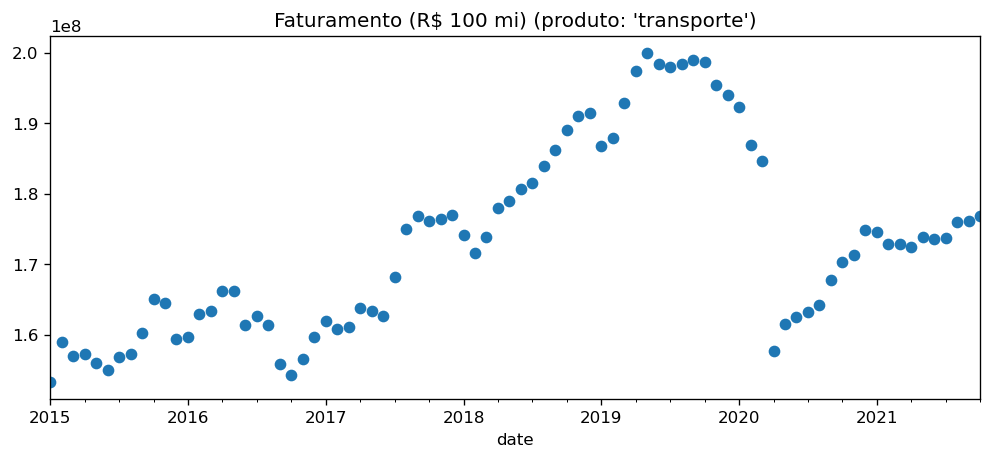

In [25]:
fat.plot(linestyle = '', marker = 'o')
plt.title(f"Faturamento (R$ 100 mi) (produto: '{analise_produto}')")
plt.show()

## Análise Exploratória

Vamos seguir o mesmo roteiro seguido para analisar os faturamentos totalizados.

In [26]:
fat.describe()

count    8.200000e+01
mean     1.729469e+08
std      1.340913e+07
min      1.532707e+08
25%      1.616310e+08
50%      1.726690e+08
75%      1.812734e+08
max      2.000000e+08
Name: transporte, dtype: float64

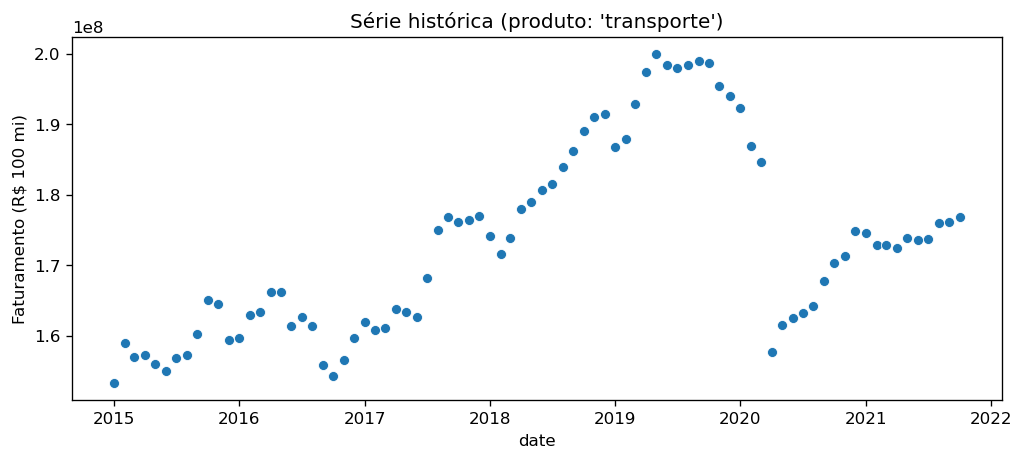

In [27]:
sns.scatterplot(data = fat)
plt.title(f"Série histórica (produto: '{analise_produto}')")
plt.ylabel("Faturamento (R$ 100 mi)")
plt.show()

Inicialmente a série temporal parece regular, embora claramente não estacionária, tanto na média (série crescente) quanto no desvio padrão (oscilações crescentes).

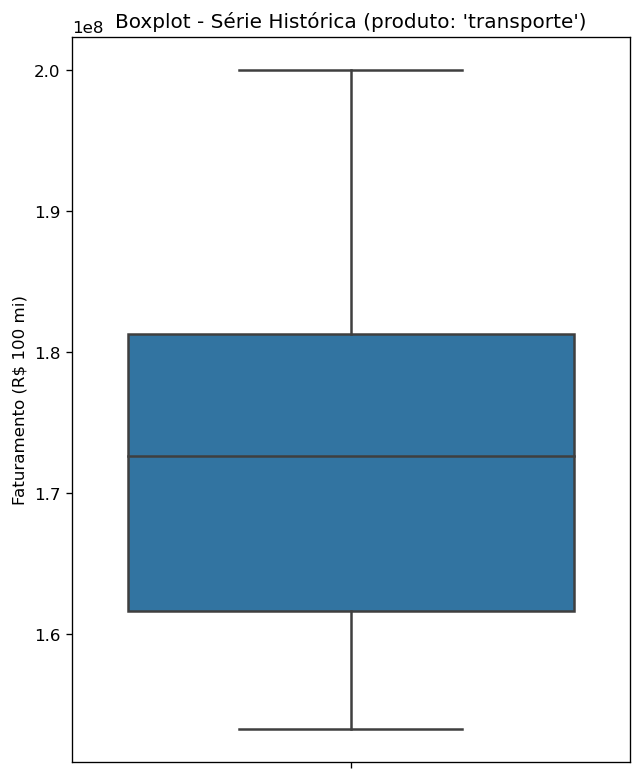

In [28]:
fig = plt.figure(figsize = (6, 8))
sns.boxplot(y = fat)
plt.ylabel('Faturamento (R$ 100 mi)')
plt.title(f"Boxplot - Série Histórica (produto: '{analise_produto}')")
plt.show()

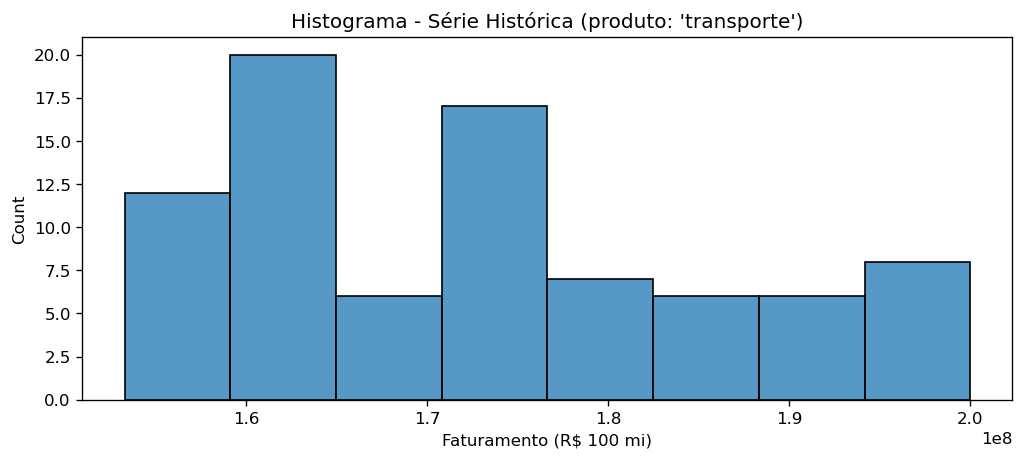

In [29]:
sns.histplot(fat)
plt.xlabel('Faturamento (R$ 100 mi)')
plt.title(f"Histograma - Série Histórica (produto: '{analise_produto}')")
plt.show()

O histograma da série completa é irregular, sem padrões distintos. Mas vejamos se conseguimos fazer uma análise melhor separando por ano.

In [30]:
n_anos = 4
anos_recentes = fat[fat.index >= dt.datetime.now() - dt.timedelta(days = n_anos * 365) + pd.tseries.offsets.YearBegin()]
anos_recentes.describe()

count    4.500000e+01
mean     1.811789e+08
std      1.182049e+07
min      1.576376e+08
25%      1.729163e+08
50%      1.789437e+08
75%      1.914235e+08
max      2.000000e+08
Name: transporte, dtype: float64

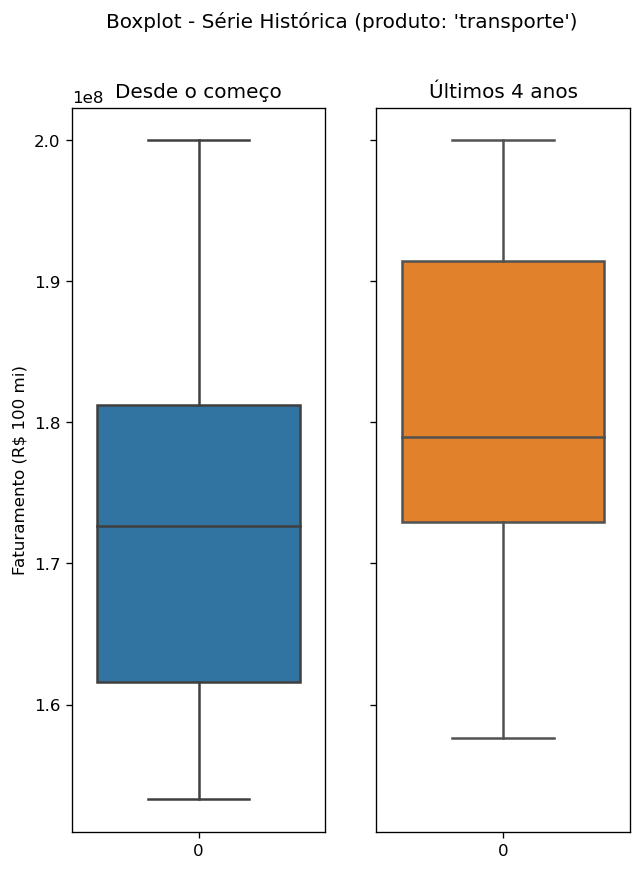

In [31]:
fig, axs = plt.subplots(ncols = 2, figsize = (6, 8), sharey = True)

palette = sns.color_palette(None, 2)

sns.boxplot(data = fat, ax = axs[0], color = palette[0])
axs[0].set_title('Desde o começo')
axs[0].set_ylabel('Faturamento (R$ 100 mi)')

sns.boxplot(data = anos_recentes, ax = axs[1], color = palette[1])
axs[1].set_title(f'Últimos {n_anos} anos')

fig.suptitle(f"Boxplot - Série Histórica (produto: '{analise_produto}')")
plt.show()

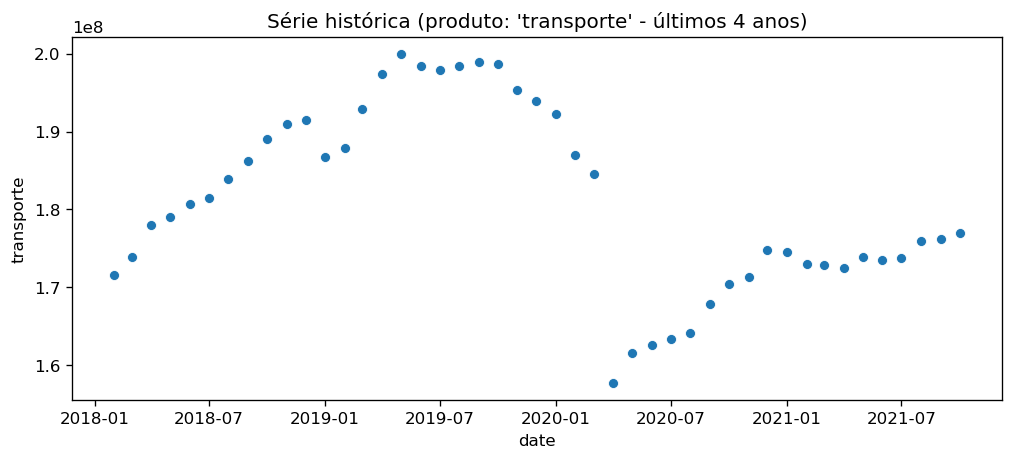

In [32]:
sns.scatterplot(data = anos_recentes)
plt.title(f"Série histórica (produto: '{analise_produto}' - últimos {n_anos} anos)")
plt.show()

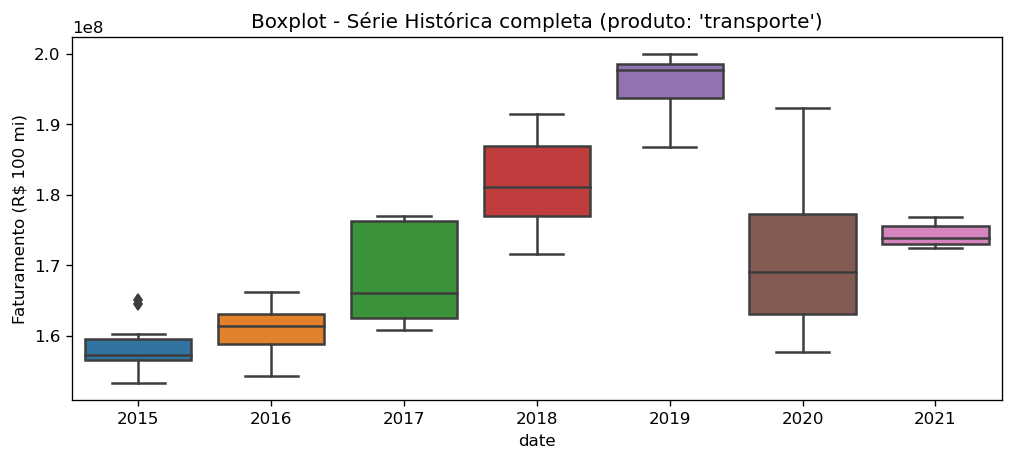

In [33]:
sns.boxplot(y = fat, x = fat.index.year)
plt.ylabel('Faturamento (R$ 100 mi)')
plt.title(f"Boxplot - Série Histórica completa (produto: '{analise_produto}')")
plt.show()

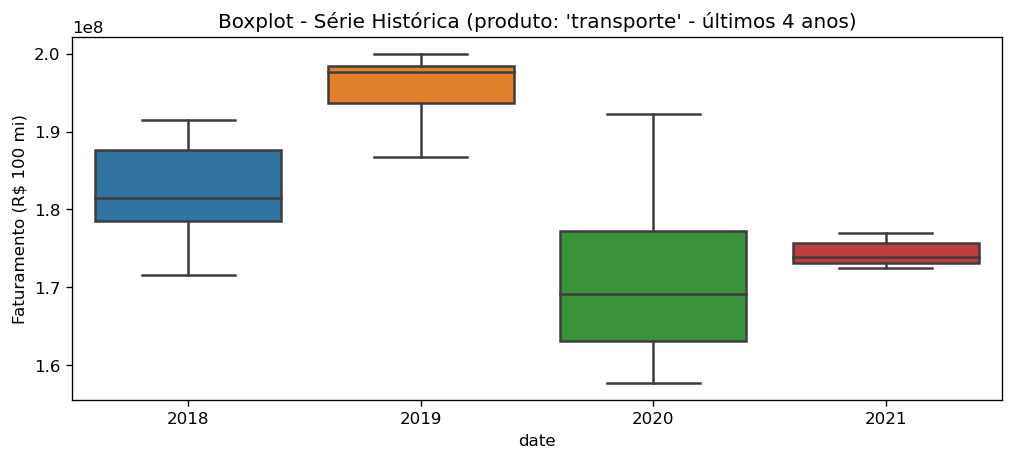

In [34]:

sns.boxplot(y = anos_recentes, x = anos_recentes.index.year)
plt.ylabel('Faturamento (R$ 100 mi)')
plt.title(f"Boxplot - Série Histórica (produto: '{analise_produto}' - últimos {n_anos} anos)")
plt.show()

O faturamento do produto `transporte` sofreu bastante com a pandemia. Por conta disso, os possíveis *outliers* de 2015 são efetivamente irrelevantes. Teremos que ser criativos para modelar a série aceitavelmente.

## Estacionariedade

Primeiramente, temos que fazer um *set-up*:

In [35]:
decomps = {}
seaborn_palette = sns.color_palette(None, n_produtos)

i_palette = {}
for i, produto in enumerate(produtos):
    i_palette[produto] = i


Antes de fazermos uma decomposição em séries de Fourier, é necessário checarmos se a série é estacionária. Faremos isso através do teste de Dickey-Fuller, como fizemos para o caso dos faturamentos totais.

In [36]:
testedf = adfuller(fat)
pvalor = testedf[1]
alpha = 0.05

print(f'Valor-p: {pvalor:.3%}', end = '')

if pvalor < alpha:
    print(f' < {alpha:.0%}')
    print('    Série de faturamentos mensais é estacionária. Rejeita-se a hipótese de a série ser um passeio aleatório.')
else:
    print(f' > {alpha:.0%}')
    print('    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).')

Valor-p: 41.492% > 5%
    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).


Essa conclusão se mantém mesmo se separarmos a série entre pré- e pós-pandemia:

In [37]:
# pré-pandemia
testedf = adfuller(fat[:'2020-01'])
pvalor = testedf[1]
alpha = 0.05

print(f'Valor-p: {pvalor:.3%}', end = '')

if pvalor < alpha:
    print(f' < {alpha:.0%}')
    print('    Série de faturamentos mensais é estacionária. Rejeita-se a hipótese de a série ser um passeio aleatório.')
else:
    print(f' > {alpha:.0%}')
    print('    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).')

Valor-p: 87.788% > 5%
    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).


In [38]:
# pós-pandemia
testedf = adfuller(fat['2020-06':])
pvalor = testedf[1]
alpha = 0.05

print(f'Valor-p: {pvalor:.3%}', end = '')

if pvalor < alpha:
    print(f' < {alpha:.0%}')
    print('    Série de faturamentos mensais é estacionária. Rejeita-se a hipótese de a série ser um passeio aleatório.')
else:
    print(f' > {alpha:.0%}')
    print('    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).')

Valor-p: 94.070% > 5%
    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).


Confirmamos que a série não é estacionária através da análise de resíduos da decomposição em séries de Fourier:

## Decomposição em séries de Fourier

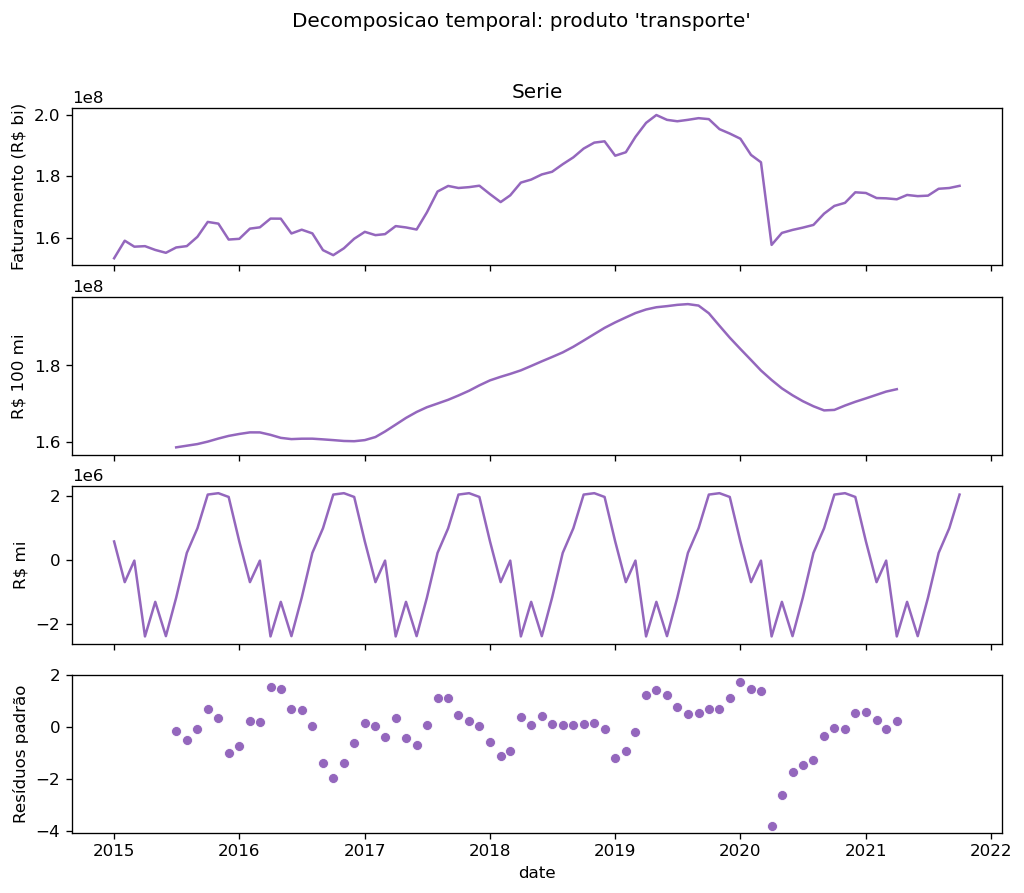

In [39]:
decomp = seasonal_decompose(fat)

fig, axs = plt.subplots(nrows = 4, figsize = (10, 8), sharex = True)

ts_filtro = tsd[analise_produto]
i = i_palette[analise_produto]
c = seaborn_palette[i]

sns.lineplot(data = ts_filtro, ax = axs[0], color = c)
axs[0].set_title('Serie')
axs[0].set_ylabel('Faturamento (R$ bi)')

sns.lineplot(data = decomp.trend, ax = axs[1], color = c)
axs[1].set_ylabel('R$ 100 mi')

sns.lineplot(data = decomp.seasonal, ax = axs[2], color = c)
axs[2].set_ylabel('R$ mi')

resid_standard = (decomp.resid - decomp.resid.mean()) / decomp.resid.std()
sns.scatterplot(data = resid_standard, ax = axs[3], color = c)
axs[3].set_ylabel('Resíduos padrão')

fig.suptitle(f"Decomposicao temporal: produto '{analise_produto}'")
plt.show()

Uma série estacionária teria seus resíduos distribuídos aleatóriamente, com por volta de 99% contidos entre -3 e +3.

Não é o que ocorre aqui. Os resíduos não estão distribuídos aleatoriamente (apresentam um padrão oscilatório).

Vejamos o que acontece se separarmos as séries entre pré- e pós-pandemia:

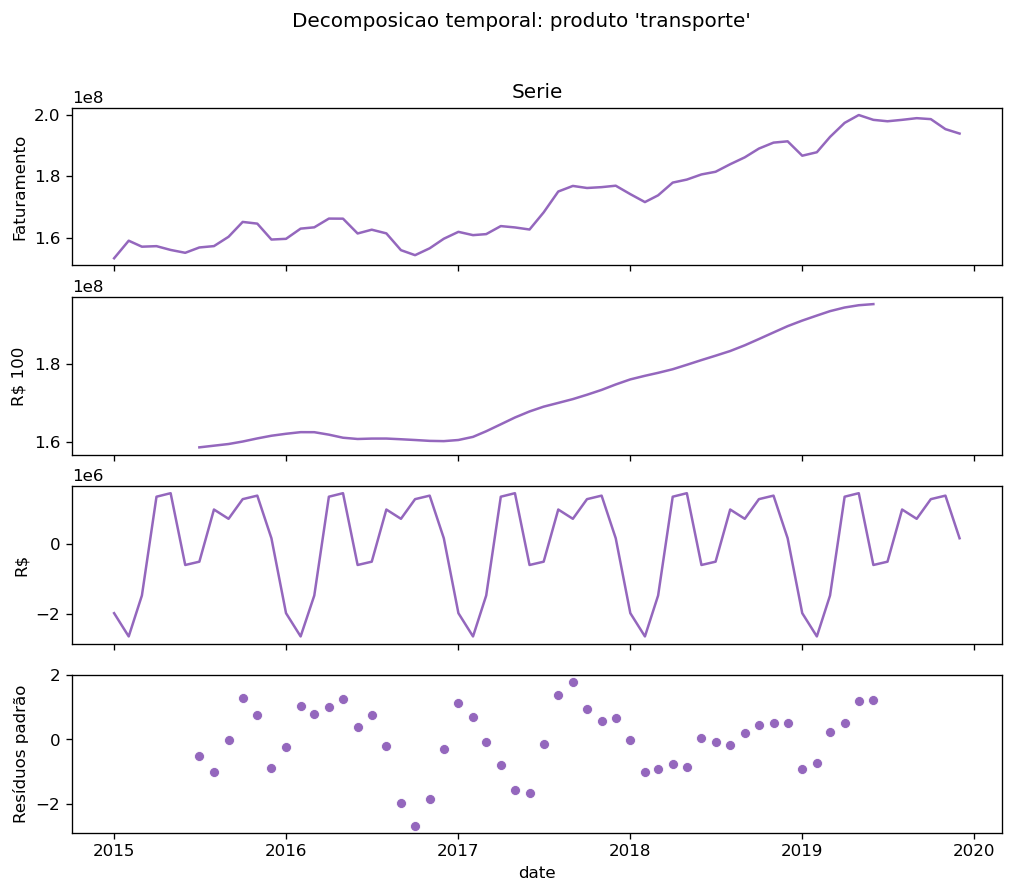

In [40]:
# pré-pandemia
decomp_pre = py_scripts.plots.decomp_fourier(serie_fat = fat[:'2020-01'].iloc[:-1], produto = analise_produto, c = c)

In [41]:
# pós-pandemia
decomp_pos = py_scripts.plots.decomp_fourier(serie_fat = fat['2020-04':], produto = analise_produto, c = c)

ValueError: x must have 2 complete cycles requires 24 observations. x only has 19 observation(s)

Nos dois últimos gráficos, há um padrão cíclico visível na série de resíduos. A decomposição em séries de Fourier não é o modelo mais adequado.

## Modelo autorregressivo

Para analisar e prever essa série temporal, é necessário um modelo mais completo. Utilizaremos aqui um modelo autorregressivo integrado de média móvel com sazonalidade - **SARIMA**.

OBS.: o modelo completo chama-se SARIMAX; o `X` adicional permite a modelagem de variáveis exógenas. No entanto, não utilizaremos variáveis exógenas neste caso.

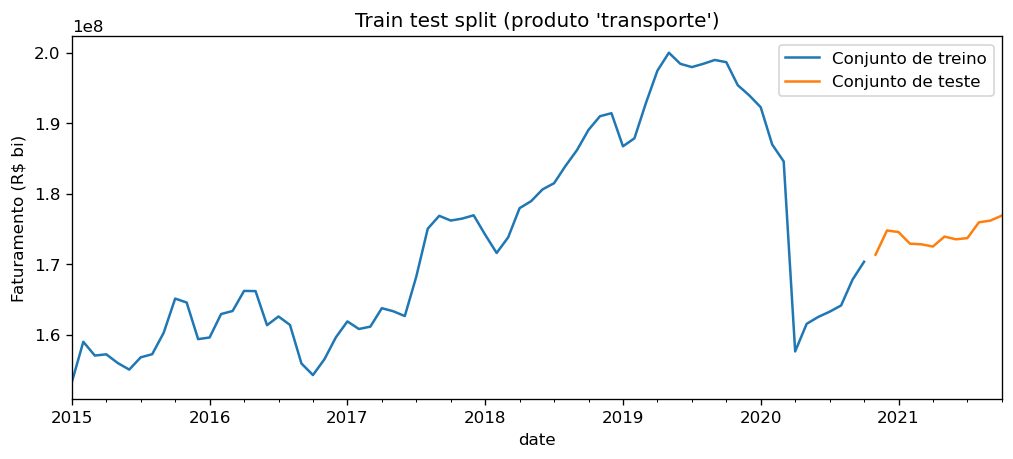

In [107]:
test_begin = '2019-01-01'
fat_train = fat[:test_begin].iloc[:-1]
fat_test = fat[test_begin:]

train_test_split_idx = int(fat.shape[0] * 0.85 + 1)
fat_train = fat[:train_test_split_idx]
fat_test = fat[train_test_split_idx:]

fat_train.plot(label = 'Conjunto de treino')
fat_test.plot(label = 'Conjunto de teste')
plt.title(f"Train test split (produto '{analise_produto}')")
plt.ylabel('Faturamento (R$ bi)')
plt.legend()
plt.show()

De cara **já vemos que a série azul e a série em laranja não cabem em um mesmo modelo**. Houve uma quebra estrutural na série; a partir de março de 2020, os eventos geradores da série são fundamentalmente diferentes dos de antes dessa data.

Mesmo assim vamos prosseguir com a análise para verificar isso quantitativamente.

Já determinamos que a série histórica não é estacionária: logo, a ordem de diferenciação (parâmetros `d` e `D` do modelo) devem ser ao menos 1.

Para determinarmos o parâmetro `d`, uma boa indicação é o gráfico de autocorrelação:

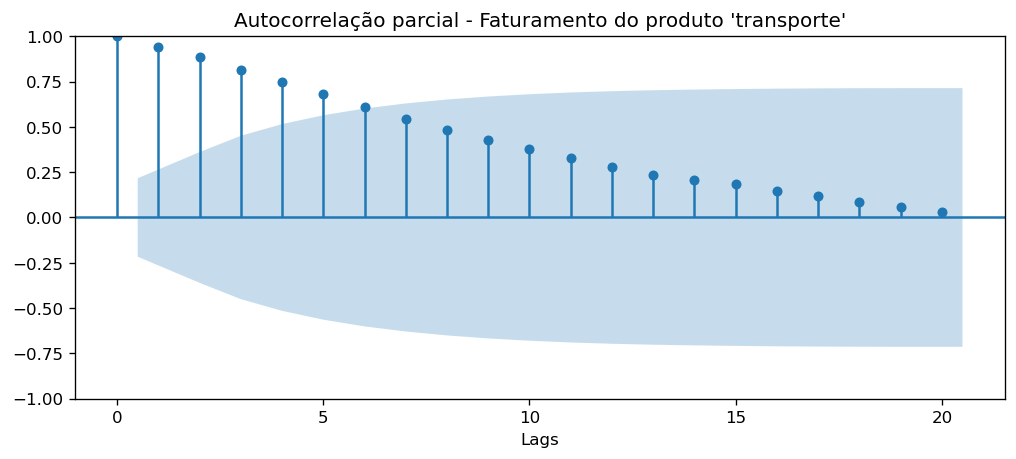

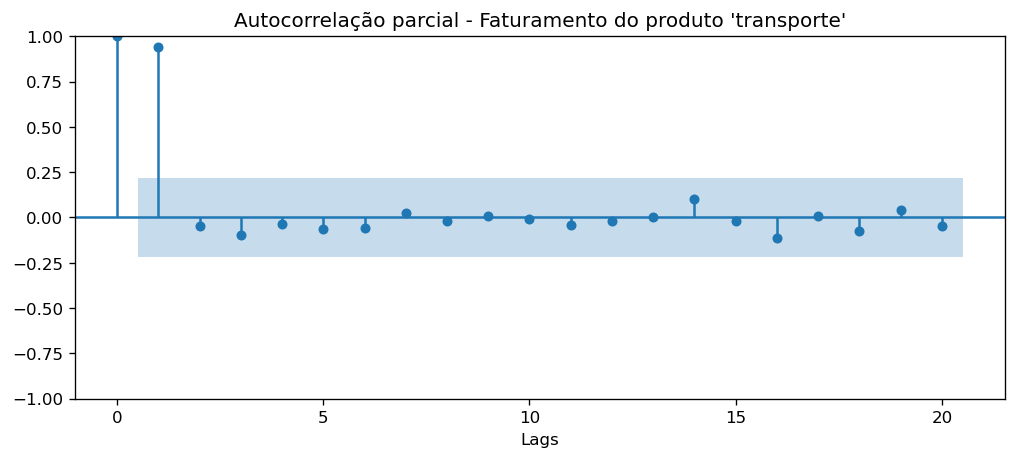

In [86]:
fig = plt.figure()
ax = fig.gca()
plot_acf(fat, lags = 20, ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação parcial - Faturamento do produto '{analise_produto}'")
plt.show()

fig = plt.figure()
ax = fig.gca()
plot_pacf(fat, lags = 20, method = 'ywm', ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação parcial - Faturamento do produto '{analise_produto}'")
plt.show()

Neste caso, uma boa estimativa para o parâmetro `d` é 1 subtraído do número de *lags* em que a correlação é estatisticamente significativa. 

Neste caso, $d \sim 1$.

In [87]:
modelo = auto_arima(
    y = fat_train,
    start_p = 1, max_p = 3,
    d = None, max_d = 3,
    start_q = 1, max_q = 3,
    start_P = 1, max_P = 3,
    D = None, max_D = 4,
    start_Q = 1, max_Q = 3,
    #max_order = 6,
    m = 12,
    seasonal = True,
    alpha = 0.05,
    stepwise = True,
    trace = True,
    n_fits = 500
)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=2376.708, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2371.132, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2372.869, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2372.882, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2369.508, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=2373.105, Time=0.18 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2373.106, Time=0.06 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2375.104, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2370.891, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2370.907, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2372.734, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 1.290 seconds


In [108]:
modelo = ARIMA(order = (0, 1, 0), seasonar_order = (0, 0, 0, 12), with_intercept = True).fit(y = fat_train)

In [109]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   70
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1150.921
Date:                Fri, 19 Nov 2021   AIC                           2305.842
Time:                        21:43:19   BIC                           2310.310
Sample:                             0   HQIC                          2307.615
                                 - 70                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.475e+05   7.98e+05      0.310      0.756   -1.32e+06    1.81e+06
sigma2      1.801e+13   1.38e+12     13.010      0.000    1.53e+13    2.07e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.90   Jarque-Bera (JB):              1541.76
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               4.67   Skew:                            -3.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Métricas para o modelo autorregressivo SARIMAX

Primeiramente, podemos avaliar o ajuste visualmente:

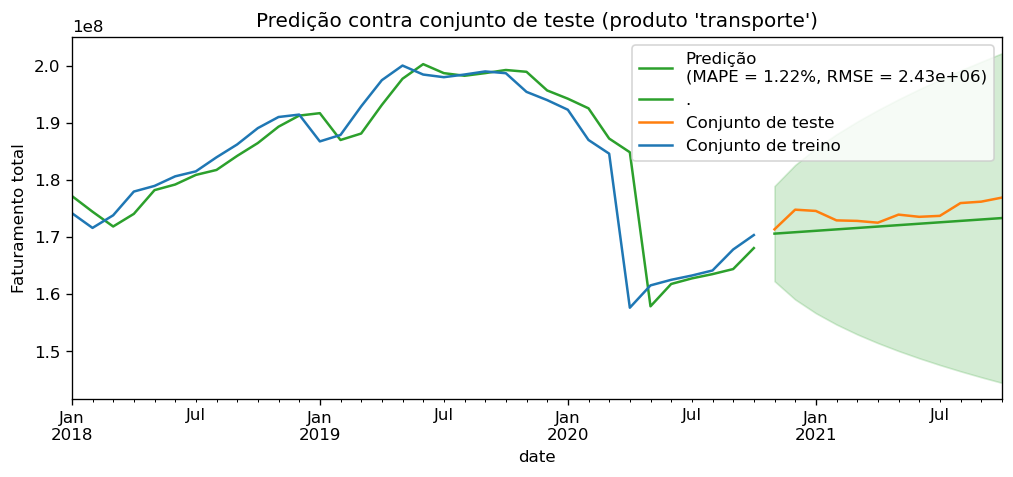

In [110]:
preds = py_scripts.plots.ajuste_grafico(
    modelo = modelo, 
    produto = analise_produto,
    serie_treino = fat_train['2018':],
    serie_teste = fat_test,
    ci = True,
    in_sample = True,
    preds_metrics = True
)

As métricas não estão tão ruins como esperado. No entanto, como falado acima, o conjunto de treino e o conjunto de teste claramente não exatamente cabem em um modelo único.

Em seguida modelaremos apenas a série pós pandemia.

## Modelo autorregressivo - Pós-pandemia

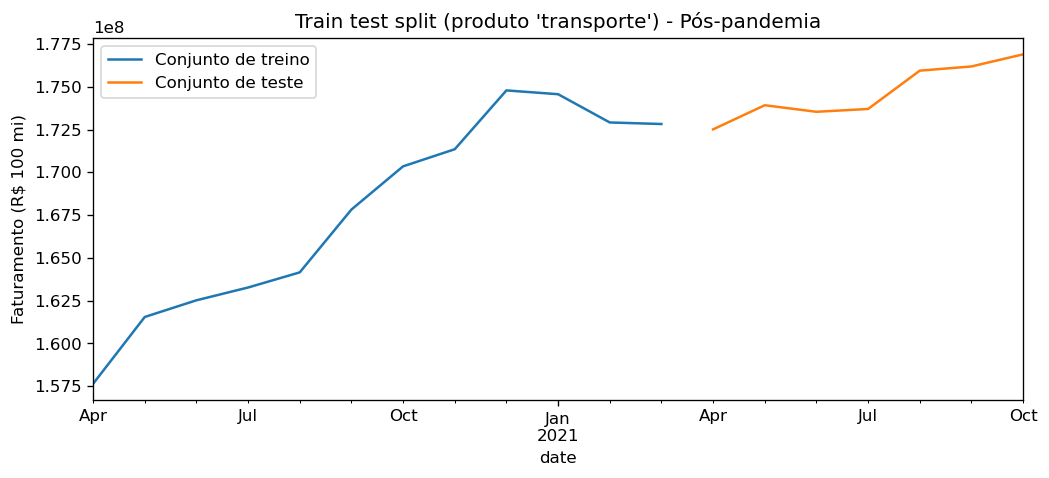

In [111]:
fat_pp = fat['2020-04':]

train_test_split_idx = int(fat_pp.shape[0] * 0.6 + 1)
fat_train = fat_pp[:train_test_split_idx]
fat_test = fat_pp[train_test_split_idx:]

fat_train.plot(label = 'Conjunto de treino')
fat_test.plot(label = 'Conjunto de teste')
plt.title(f"Train test split (produto '{analise_produto}') - Pós-pandemia")
plt.ylabel('Faturamento (R$ 100 mi)')
plt.legend()
plt.show()

Agora as séries parecem parte de um mesmo modelo. No entanto, **parece haver bem poucos dados**.

Vamos determinar a estacionariedade da série:

In [61]:
testedf = adfuller(fat_pp)
pvalor = testedf[1]
alpha = 0.05

print(f'Valor-p: {pvalor:.3%}', end = '')

if pvalor < alpha:
    print(f' < {alpha:.0%}')
    print('    Série de faturamentos mensais é estacionária. Rejeita-se a hipótese de a série ser um passeio aleatório.')
else:
    print(f' > {alpha:.0%}')
    print('    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).')

Valor-p: 2.974% < 5%
    Série de faturamentos mensais é estacionária. Rejeita-se a hipótese de a série ser um passeio aleatório.


A série é estacionária, logo em princípio é válido fazer uma decomposição em série de Fourier. No entanto, há poucos dados para tal.

In [51]:
py_scripts.plots.decomp_fourier(serie_fat = fat_pp, produto = analise_produto, c = c)

ValueError: x must have 2 complete cycles requires 24 observations. x only has 19 observation(s)

Já determinamos que a série histórica é estacionária: logo, a ordem de diferenciação (parâmetros `d` e `D` do modelo) podem ser 0.

Para determinarmos o parâmetro `d`, uma boa indicação é o gráfico de autocorrelação:

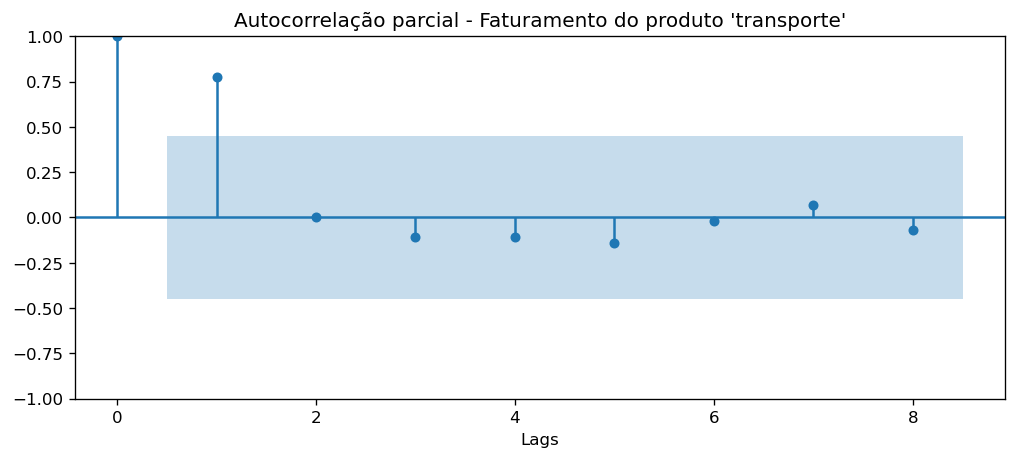

In [62]:
fig = plt.figure()
ax = fig.gca()
plot_pacf(fat_pp, lags = 8, method = 'ywm', ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação parcial - Faturamento do produto '{analise_produto}'")
plt.show()

Neste caso, uma boa estimativa para o parâmetro `d` é 1 subtraído do número de *lags* em que a correlação é estatisticamente significativa. 

Neste caso, $d \sim 1$.

Há indícios conflitantes, mas podemos testar todos os `d`s e ver qual mais se ajusta.

In [113]:
modelo_pp = auto_arima(
    y = fat_train,
    start_p = 1, max_p = 3,
    d = 0, max_d = 4,
    start_q = 1, max_q = 3,
    start_P = 1, max_P = 3,
    D = None, max_D = 4,
    start_Q = 1, max_Q = 3,
    #max_order = 6,
    m = 12,
    seasonal = True,
    alpha = 0.05,
    stepwise = True,
    trace = True,
    n_fits = 500
)


ValueError: There are no more samples after a first-order seasonal differencing. See http://alkaline-ml.com/pmdarima/seasonal-differencing-issues.html for a more in-depth explanation and potential work-arounds.

In [114]:
modelo_pp = ARIMA(order = (0, 1, 0), with_intercept = True).fit(y = fat_train)

In [115]:
modelo_pp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   12
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -173.463
Date:                Fri, 19 Nov 2021   AIC                            350.925
Time:                        21:44:12   BIC                            351.721
Sample:                             0   HQIC                           350.423
                                 - 12                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.381e+06   5.15e+05      2.679      0.007    3.71e+05    2.39e+06
sigma2      2.915e+12   1.79e+12      1.630      0.103   -5.89e+11    6.42e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):                 0.49
Prob(Q):                              0.49   Prob(JB):                         0.78
Heteroskedasticity (H):               2.53   Skew:                             0.05
Prob(H) (two-sided):                  0.39   Kurtosis:                         1.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

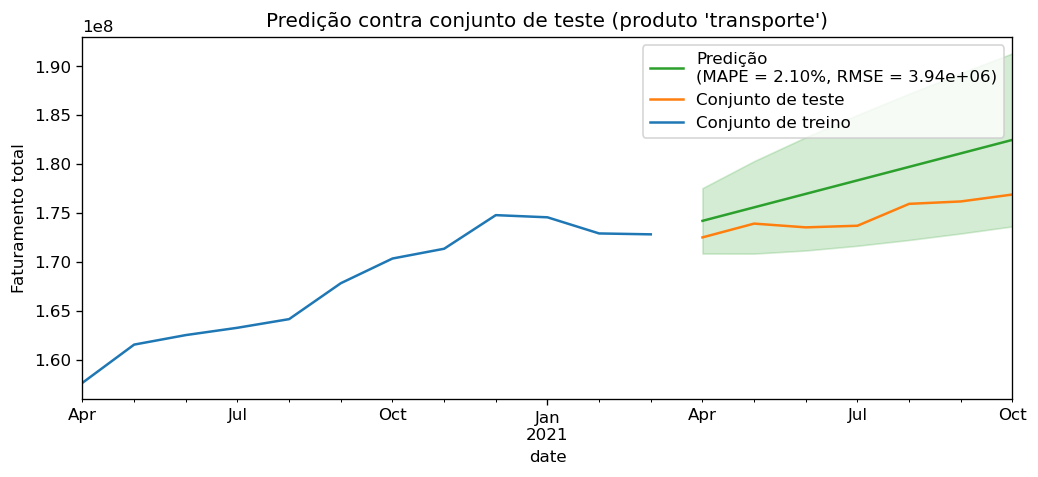

In [116]:
preds = py_scripts.plots.ajuste_grafico(
    modelo = modelo_pp, 
    produto = analise_produto,
    serie_treino = fat_train,
    serie_teste = fat_test['2018-01':],
    ci = True,
    in_sample = False,
    preds_metrics = True
)

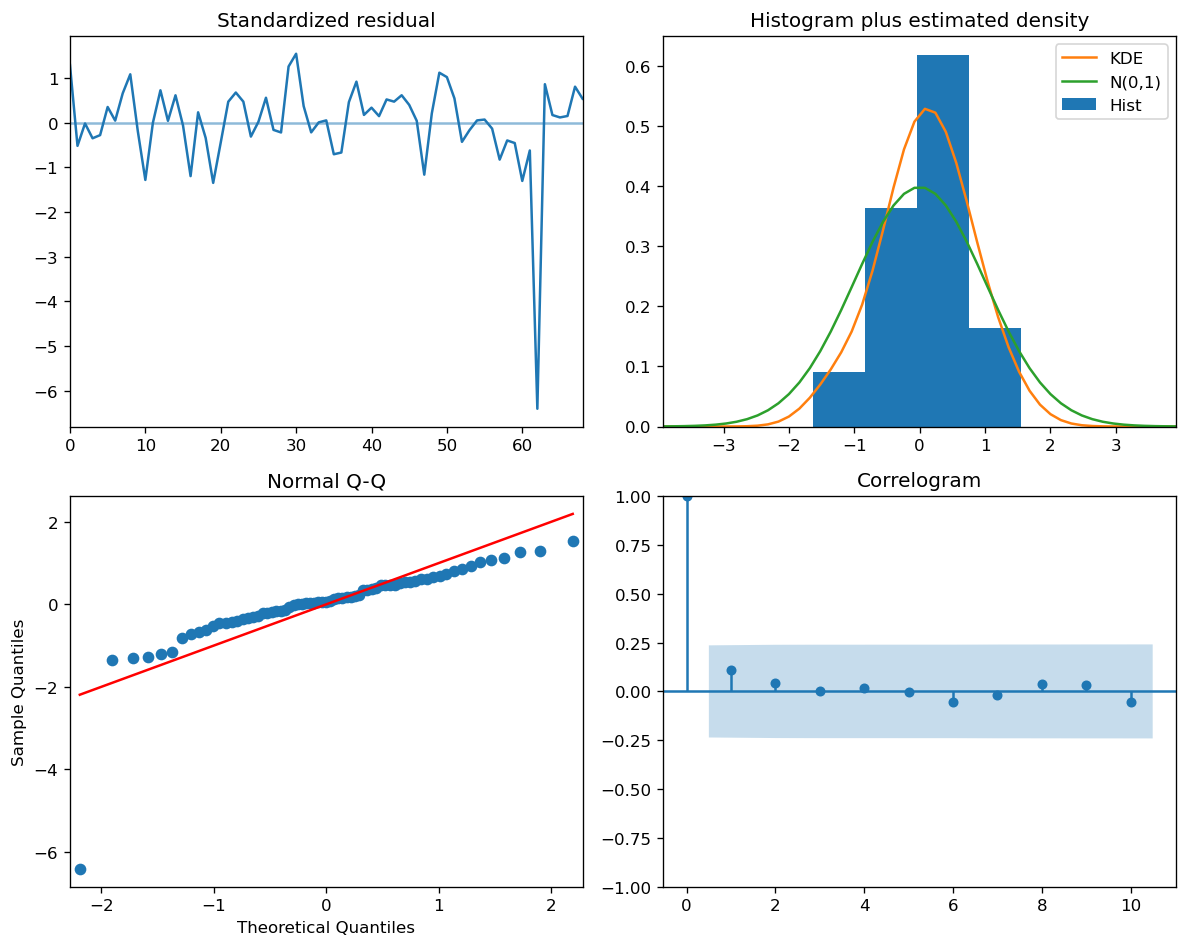

In [117]:

modelo.plot_diagnostics(figsize = (10, 8))
plt.tight_layout()
plt.show()

In [118]:
kwargs_total = dict(
    y_true = fat_test,
    y_pred = preds,
    n = fat_train.shape[0],
    dof = modelo.df_model()
)

metricas = py_scripts.metrics.mostrar_metricas(**kwargs_total)

Métricas:
       MAPE: 2.098%
       RMSE: 3.941e+06
        MAE: 3.674e+06


Como dissemos acima, os dados que temos não são suficientes para ajustarmos um modelo autorregressivo.

Vamos tentar algo diferente.

## Modelo autorregressivo - Pós-pandemia com dados simulados

Olhando novamente para a série histórica a partir de 2017...

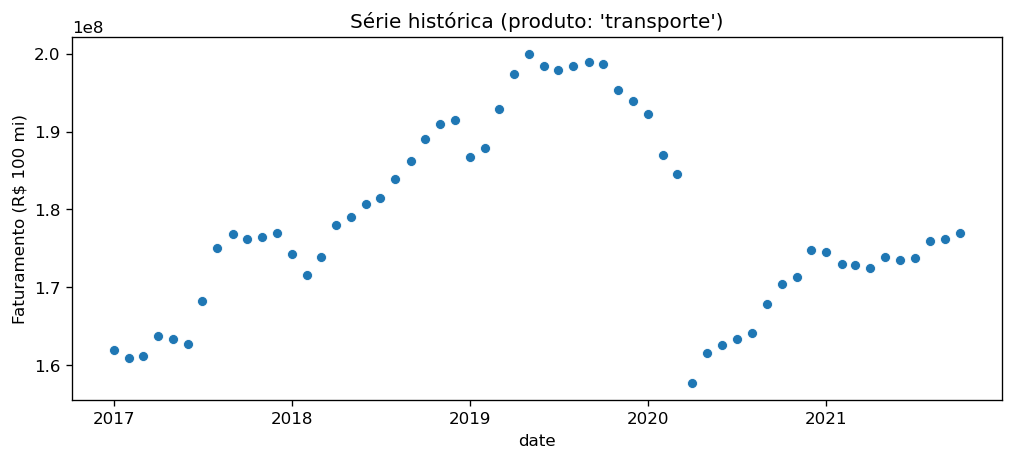

In [ ]:
inicio = '2017-01'
fat_replicar = fat[inicio:]
sns.scatterplot(data = fat_replicar)
plt.title(f"Série histórica (produto: '{analise_produto}')")
plt.ylabel("Faturamento (R$ 100 mi)")
plt.show()

... vemos um padrão interessante:

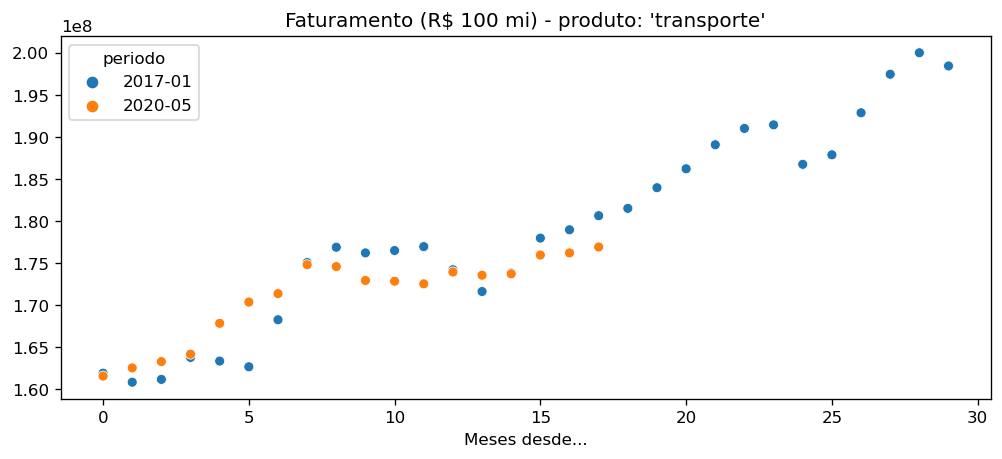

In [ ]:
inicio_pos_pandemia = '2020-05'
serie2 = fat_replicar[inicio_pos_pandemia:].reset_index(drop=True)
serie1 = fat_replicar[:'2019-06'].reset_index(drop = True)

comparacao_dict = {
    f'{inicio}': serie1,
    f'{inicio_pos_pandemia}': serie2,
}
comparacao_wide = (pd.DataFrame(comparacao_dict)
    .reset_index()
    .rename(columns = {'index': 'n_mes'})
)

comparacao = pd.melt(comparacao_wide, var_name = 'periodo', value_name = 'faturamento', id_vars = 'n_mes')

sns.scatterplot(data = comparacao, y = 'faturamento', x = 'n_mes', hue = 'periodo')

plt.xlabel('Meses desde...')
plt.ylabel('')
plt.title(f"Faturamento (R$ 100 mi) - produto: '{analise_produto}'")
plt.show()

A série histórica que iniciou em 2017 parece se repetir no pós pandemia:

In [ ]:
t_stat, p_valor = spst.ttest_ind(serie2, serie1[:serie2.shape[0]])
print(f'(valor-p = {p_valor:.2%}) ', end = '')
if p_valor < 0.05:
    print('Séries são estatisticamente diferentes. Rejeita-se a hipótese nula de diferença entre conjuntos igual a zero.')
else:
    print('Séries não são estatisticamente diferentes. Não rejeita-se a hipótese nula de diferença entre conjuntos igual a zero.')

(valor-p = 96.37%) Séries não são estatisticamente diferentes. Não rejeita-se a hipótese nula de diferença entre conjuntos igual a zero.


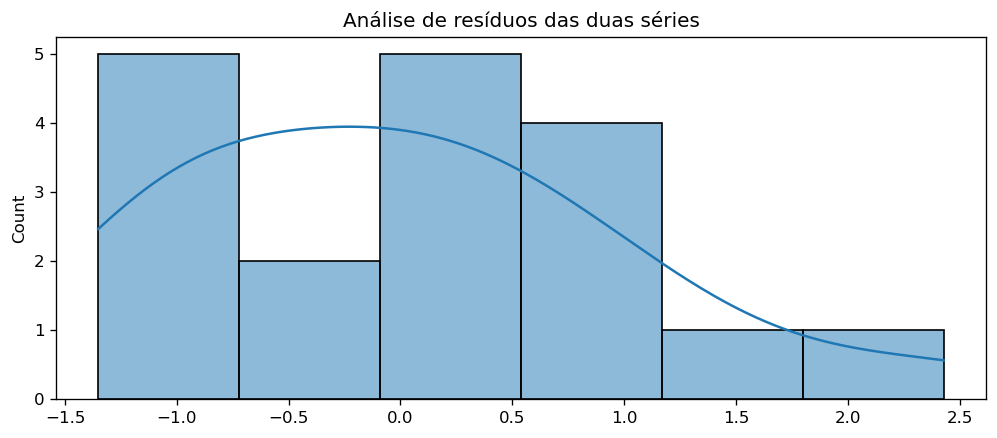

In [ ]:
teste = comparacao_wide.dropna()
dif = teste[inicio_pos_pandemia] - teste[inicio]
resids = (dif - dif.mean())/dif.std()
sns.histplot(data = resids, kde = True)
plt.title('Análise de resíduos das duas séries')
plt.show()

Os resíduos são aproximadamente normais, de forma que o teste T de amostras independentes é válido. Ele diz que as séries não são significativamente diferentes.

Então, vamos fazer uma projeção baseada na série iniciada em 2017, e então ajustamos a essa série "simulada" um modelo autorregressivo.

In [ ]:
col_pre_pandemia, col_pos_pandemia = comparacao_wide.columns[1:3]
comparacao_wide['faturamento_simulado'] = comparacao_wide[col_pos_pandemia].where(cond = comparacao_wide[col_pos_pandemia].notna(), other = comparacao_wide[col_pre_pandemia]) 
comparacao_wide['date'] = pd.date_range(start = col_pos_pandemia, periods = comparacao_wide.shape[0], freq = 'MS')

fat_sim = comparacao_wide.set_index('date')['faturamento_simulado']

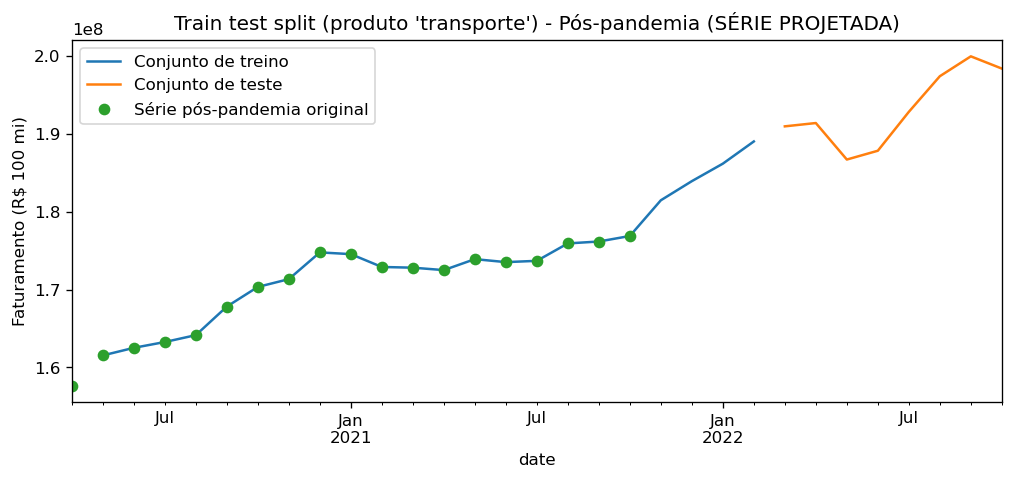

In [ ]:
train_test_split_idx = int(fat_sim.shape[0] * 0.7 + 1)
fat_train = fat_sim[:train_test_split_idx]
fat_test = fat_sim[train_test_split_idx:]

fat_train.plot(label = 'Conjunto de treino')
fat_test.plot(label = 'Conjunto de teste')
fat_pp.plot(label = 'Série pós-pandemia original', marker = 'o', linestyle = '')
plt.title(f"Train test split (produto '{analise_produto}') - Pós-pandemia (SÉRIE PROJETADA)")
plt.ylabel('Faturamento (R$ 100 mi)')
plt.legend()
plt.show()

Agora as séries parecem parte de um mesmo modelo. No entanto, **parece haver bem poucos dados**.

Vamos determinar a estacionariedade da série:

In [ ]:
testedf = adfuller(fat_sim)
pvalor = testedf[1]
alpha = 0.05

print(f'Valor-p: {pvalor:.3%}', end = '')

if pvalor < alpha:
    print(f' < {alpha:.0%}')
    print('    Série de faturamentos mensais é estacionária. Rejeita-se a hipótese de a série ser um passeio aleatório.')
else:
    print(f' > {alpha:.0%}')
    print('    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).')

Valor-p: 92.689% > 5%
    Série de faturamentos mensais é um passeio aleatório. Não podemos rejeitar a hipótese nula (random walk).


Já determinamos que a série histórica não é estacionária: logo, a ordem de diferenciação (parâmetros `d` e `D` do modelo) é no míninmo 1.

Para determinarmos o parâmetro `d`, uma boa indicação é o gráfico de autocorrelação:

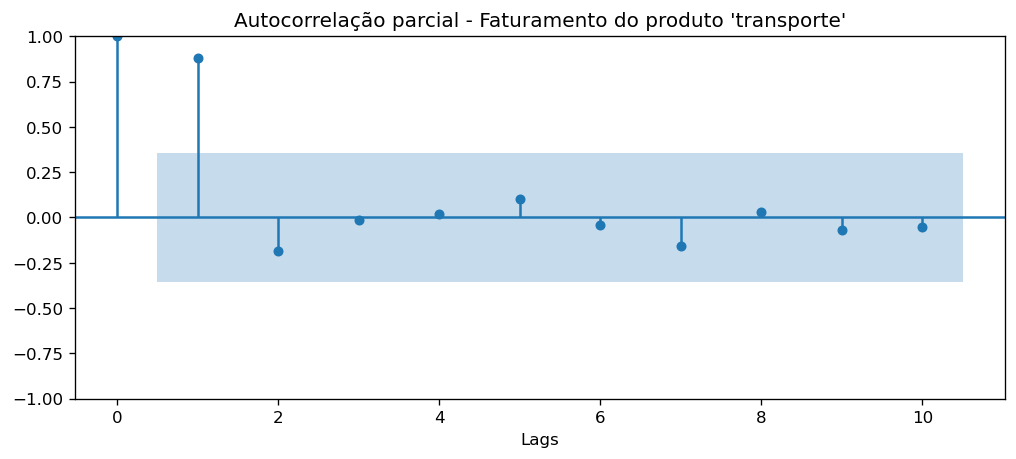

In [ ]:
fig = plt.figure()
ax = fig.gca()
plot_pacf(fat_sim, lags = 10, method = 'ywm', ax = ax)
ax.set_xlabel('Lags')
ax.set_title(f"Autocorrelação parcial - Faturamento do produto '{analise_produto}'")
plt.show()

Neste caso, uma boa estimativa para o parâmetro `d` é 1 subtraído do número de *lags* em que a correlação é estatisticamente significativa. 

Neste caso, $d \sim 1$.

Há indícios conflitantes, mas podemos testar todos os `d`s e ver qual mais se ajusta.

In [ ]:
modelo_ppsim = auto_arima(
    y = fat_train,
    start_p = 1, max_p = 3,
    d = 1, max_d = 4,
    start_q = 1, max_q = 3,
    start_P = 1, max_P = 3,
    D = None, max_D = 4,
    start_Q = 1, max_Q = 3,
    #max_order = 6,
    m = 12,
    seasonal = True,
    alpha = 0.05,
    stepwise = False,
    trace = True,
    n_fits = 500,
    suppress_warnings=True,
)


 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=662.033, Time=0.01 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=664.031, Time=0.02 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=666.031, Time=0.04 sec
 ARIMA(0,1,0)(0,0,3)[12] intercept   : AIC=668.031, Time=0.09 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=664.031, Time=0.04 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=666.031, Time=0.11 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=668.031, Time=0.19 sec
 ARIMA(0,1,0)(1,0,3)[12] intercept   : AIC=670.031, Time=0.28 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=666.031, Time=0.09 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=668.031, Time=0.20 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=670.031, Time=0.22 sec
 ARIMA(0,1,0)(2,0,3)[12] intercept   : AIC=672.031, Time=0.40 sec
 ARIMA(0,1,0)(3,0,0)[12] intercept   : AIC=668.031, Time=0.18 sec
 ARIMA(0,1,0)(3,0,1)[12] intercept   : AIC=670.031, Time=1.27 sec
 ARIMA(0,1,0)(3,0,2)[12] intercept   : AIC=672.031, Time=1.01 sec
 ARIMA(0,1

In [ ]:
modelos_aceitaveis = [
    ARIMA(order = (0, 1, 0), seasonal_order = (0, 0, 0, 12), with_intercept = True).fit(y = fat_train)
]

In [ ]:
modelo_ppsim.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   22
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -329.016
Date:                Fri, 19 Nov 2021   AIC                            662.033
Time:                        19:01:40   BIC                            664.122
Sample:                             0   HQIC                           662.486
                                 - 22                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    1.31e+06   3.47e+05      3.776      0.000     6.3e+05    1.99e+06
sigma2      2.377e+12   9.08e+11      2.619      0.009    5.99e+11    4.16e+12
===================================================================================
Ljung-Box (L1) (Q):                   1.76   Jarque-Bera (JB):                 0.62
Prob(Q):                              0.18   Prob(JB):                         0.74
Heteroskedasticity (H):               1.44   Skew:                             0.29
Prob(H) (two-sided):                  0.64   Kurtosis:                         2.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Métricas para o modelo autorregressivo SARIMAX

Primeiramente, podemos avaliar o ajuste visualmente:

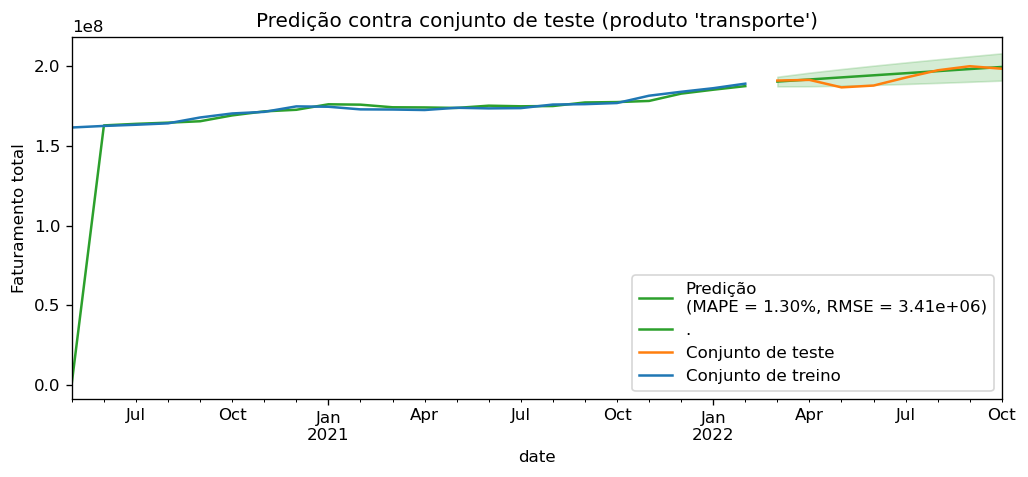

In [ ]:
preds = py_scripts.plots.ajuste_grafico(
    modelo = modelo_ppsim, 
    produto = analise_produto,
    serie_treino = fat_train,
    serie_teste = fat_test['2018-01':],
    ci = True,
    in_sample = True,
    preds_metrics = True
)

O modelo ARIMA ajustados somente aos dados pós pandemia tem os mesmos parâmetros (`ARIMA(0, 1, 0)` com intercepto, sem componente sazonal) que os ajustados aos dados completos. Embora o AIC seja bem menor no modelo com dados pós-pandemia (AIC = 662) do que no modelo com dados completos (AIC = 2304, perfazendo **uma redução de -71% em favor do modelo com dados simulados**), a métrica de acurácia percentual, MAPE, não acompanha essa magnitude de diferença (respectivamente, MAPEs de 1,3% e 2,14%, perfazendo **uma redução de -0,84 p.p. ou -39,2% em favor do modelo com dados simulados**).

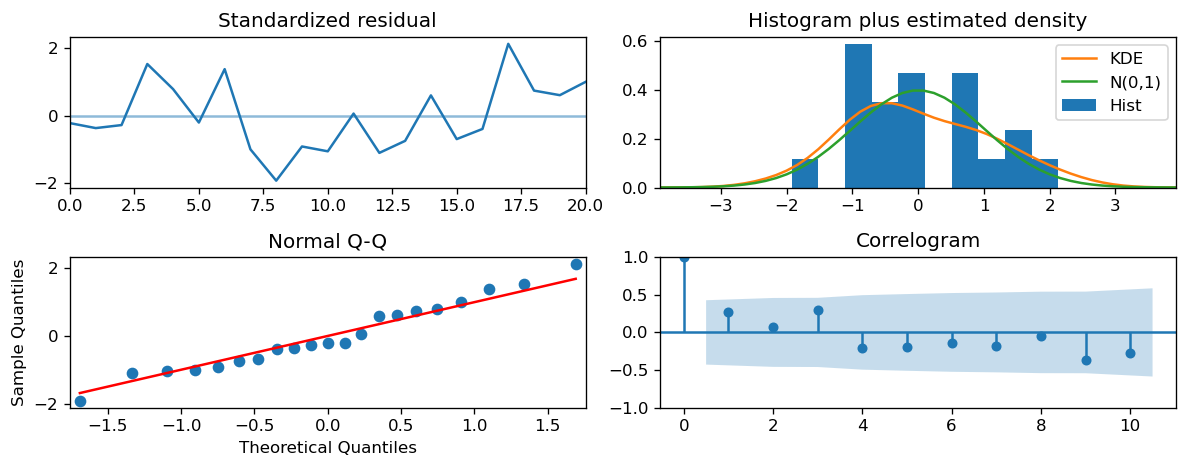

In [ ]:
modelo.plot_diagnostics()
plt.tight_layout()
plt.show()

Aparentemente está OK. No entanto, devemos nos lembrar que **este é um modelo sintético!**

Vamos aplicar algumas métricas quantitativas ao modelo:

In [ ]:
kwargs_total = dict(
    y_true = fat_test,
    y_pred = preds,
    n = fat_train.shape[0],
    dof = modelo.df_model()
)

metricas = py_scripts.metrics.mostrar_metricas(**kwargs_total)

Métricas:
       MAPE: 1.297%
       RMSE: 3.414e+06
        MAE: 2.467e+06
